# RUN PERFORMANCE PROJECT - Pau Sampietro

## Data Exploratory Analysis & Visualization 

In this file we start doing some explorations over the data, performing some statistical analysis and giving some insights based on results and explanatory plots.
Some of the hypothesis that we will demonstrate are: 
 * Pace in track (min/km) is normally distributted for a given period of time. (Goodness of fit)
 * Comparison between Athletes: ***Armand*** is significantly faster than ***Pau***
 * The longer the run, the slower the pace
 * The more accumulated ascent, the higher heart rate
    
1. Descriptive statistics
2. Explanatory plots and interactive visualizations
3. Hypothesis testing, if needed

In [14]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import plotly.plotly as py
import matplotlib.pyplot as plt
import cufflinks as cf 
from ipywidgets import interact
import plotly.graph_objs as go
from rpdb import read_table, export_table

### Import Data from the Google Cloud Database

We start importing the "moves" table, in order to perform some exploratory analysis of the moves.

In [5]:
moves = read_table('moves')

### ***Moves.*** Descriptive Statistics & Visualizations

In [7]:
moves.describe()

,index,move,distance,calories,accum_ascent,moving_time,pace
count,813.000000,813.000000,813.000000,805.000000,813.000000,813.000000,813.000000
mean,406.000000,409.403444,11565.228782,980.472050,272.048462,65.041574,5.649705
std,234.837178,236.370080,9706.896844,913.117682,436.308980,71.739980,2.591408
min,0.000000,1.000000,29.000000,0.000000,0.000000,0.700000,3.560000
25%,203.000000,205.000000,6043.000000,511.000000,75.000000,32.100000,4.820000
50%,406.000000,409.000000,10026.000000,778.000000,160.000000,51.700000,5.110000
75%,609.000000,614.000000,14459.000000,1222.000000,325.400000,78.500000,5.580000
max,812.000000,817.000000,159600.000000,15485.000000,7922.600000,1357.400000,48.280000


In [11]:
moves['distance'][moves.athlete=='P'].mean()

8530.279720279721

In [12]:
moves['distance'][moves.athlete=='A'].mean()

12212.986567164178

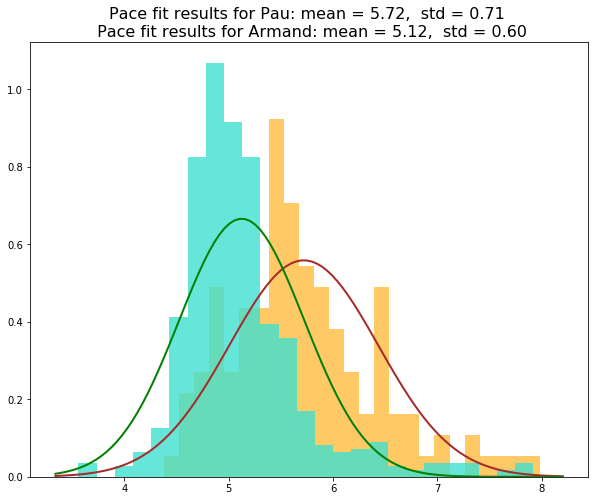

In [63]:
# Fitting a normal distribution to the data:
data_p = moves['pace'][(moves.pace > 2) & (moves.pace < 8) & (moves.athlete == 'P')]
data_a = moves['pace'][(moves.pace > 2) & (moves.pace < 8) & (moves.athlete == 'A')]
mu_p, std_p = stats.norm.fit(data_p)
mu_a, std_a = stats.norm.fit(data_a)

# Plotting Histograms for both Pau and Armand pacing
plt.figure(figsize=(10,8))
plt.hist(data_p, bins = 25, density=True, alpha=0.6, color='orange')
plt.hist(data_a, bins = 25, density=True, alpha=0.8, color='turquoise')

#Plotting normal distributions (PDF)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p_p = stats.norm.pdf(x, mu_p, std_p)
p_a = stats.norm.pdf(x, mu_a, std_a)
plt.plot(x, p_p, 'k', linewidth=2, color = 'brown')
plt.plot(x, p_a, 'k', linewidth=2, color = 'green')

title = """Pace fit results for Pau: mean = %.2f,  std = %.2f \n Pace fit results for Armand: mean = %.2f,  std = %.2f""" % (mu_p, std_p, mu_a, std_a)
plt.title(title, fontsize = 16)
plt.show()


confidence intervals: loc= mean, scale = std

In [ ]:
stats.norm.interval(0.95, loc=0, scale=1)

one sample test

In [ ]:
# Your code here:
# Ho : are 30$/dollar
# H1 : not really

from scipy.stats import ttest_1samp

stat, p = ttest_1samp(salaries['Hourly Rate'][ salaries['Hourly Rate'].isnull() == False],30)
p

function to perform 2 sample test in many features

In [ ]:
def t_test_features(s1, s2, features=['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Total']):
    """Test means of a feature set of two samples
    
    Args:
        s1 (dataframe): sample 1
        s2 (dataframe): sample 2
        features (list): an array of features to test
    
    Returns:
        dict: a dictionary of t-test scores for each feature where the feature name is the key and the p-value is the value
    """
    results = {}

    # Your code here
    
    return results

We can conduct ANOVA test if std of armands move and paus moves are equal.

In [64]:
cf.go_offline()
trace_p = go.Scatter(
    x=moves['distance'][moves.athlete == 'P'],
    y=moves['moving_time'][moves.athlete == 'P'],
    mode='markers',
    marker=dict(size=12,
                line=dict(width=1),
                color='turquoise'
               ),
    name="Pau's moves"
    )
trace_a = go.Scatter(
    x=moves['distance'][moves.athlete == 'A'],
    y=moves['moving_time'][moves.athlete == 'A'],
    mode='markers',
    marker=dict(size=12,
                line=dict(width=1),
                color='orange'
               ),
    name="Armand's moves",
    )
data_comp = [trace_p, trace_a]

layout_comp = go.Layout(
    title="Pau and Armand's moves",
    hovermode='closest',
    xaxis=dict(
        title='distance(m)',
        ticklen=5,
        gridwidth=2,
    ),
    yaxis=dict(
        title='moving time(s)',
        ticklen=5,
        gridwidth=2,
    ),
)
fig_comp = go.Figure(data=data_comp, layout=layout_comp)
fig_comp.iplot(filename='ap3')